/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Time taken for K-means clustering: 1.3269 seconds


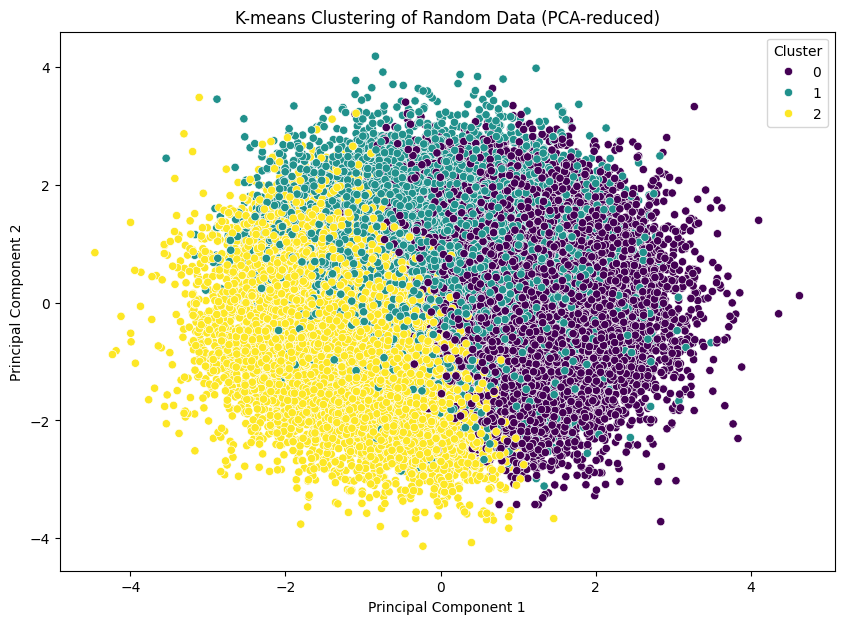

Iteration 1 centroids:
[[ 0.38525675 -0.64183181  0.68047183 -0.07875021 -0.17288424]
 [ 0.0081751  -0.00425303 -0.55303924  0.14860902  0.87949015]
 [-0.39765583  0.6533013  -0.14576068 -0.06611749 -0.68779772]]
Iteration 2 centroids:
[[ 0.38525675 -0.64183181  0.68047183 -0.07875021 -0.17288424]
 [ 0.0081751  -0.00425303 -0.55303924  0.14860902  0.87949015]
 [-0.39765583  0.6533013  -0.14576068 -0.06611749 -0.68779772]]
Iteration 3 centroids:
[[ 0.38525675 -0.64183181  0.68047183 -0.07875021 -0.17288424]
 [ 0.0081751  -0.00425303 -0.55303924  0.14860902  0.87949015]
 [-0.39765583  0.6533013  -0.14576068 -0.06611749 -0.68779772]]
Iteration 4 centroids:
[[ 0.38525675 -0.64183181  0.68047183 -0.07875021 -0.17288424]
 [ 0.0081751  -0.00425303 -0.55303924  0.14860902  0.87949015]
 [-0.39765583  0.6533013  -0.14576068 -0.06611749 -0.68779772]]
Iteration 5 centroids:
[[ 0.38525675 -0.64183181  0.68047183 -0.07875021 -0.17288424]
 [ 0.0081751  -0.00425303 -0.55303924  0.14860902  0.87949015]

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# Generate random data
np.random.seed(42)  # For reproducibility
num_samples = 100000
num_features = 5
data = pd.DataFrame(np.random.randn(num_samples, num_features), columns=[f'feature_{i}' for i in range(num_features)])

# Preprocess the data
data = data.select_dtypes(include=[float])

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply K-means clustering and measure time
start_time = time.time()

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42, max_iter=10)
kmeans.fit(scaled_data)

end_time = time.time()

# Calculate the time taken for K-means clustering
clustering_time = end_time - start_time
print("Time taken for K-means clustering: {:.4f} seconds".format(clustering_time))

# Add the cluster labels to the original dataset
data['Cluster'] = kmeans.labels_

# Optionally, visualize the clusters
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df['Cluster'] = data['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='viridis', data=pca_df, marker='o')
plt.title('K-means Clustering of Random Data (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Print centroids after each iteration
for i in range(1, kmeans.n_iter_ + 1):
    print(f"Iteration {i} centroids:")
    print(kmeans.cluster_centers_)


In [17]:
%%writefile kmeans_rnd.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <math.h>
#include <cuda.h>

#define N 100000  // Number of data points
#define D 5      // Number of dimensions (features)
#define TPB 32   // Threads per block
#define K 3      // Number of clusters
#define MAX_ITER 10

void generateRandomData(float *data, int n, int d) {
    for (int i = 0; i < n * d; ++i) {
        data[i] = (float)rand() / (float)RAND_MAX;
    }
}

__device__ float distance(float *a, float *b, int dims) {
    float dist = 0;
    for (int i = 0; i < dims; ++i) {
        dist += (a[i] - b[i]) * (a[i] - b[i]);
    }
    return sqrt(dist);
}

__global__ void kMeansClusterAssignment(float *d_datapoints, int *d_clust_assn, float *d_centroids) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx >= N) return;

    float min_dist = INFINITY;
    int closest_centroid = 0;

    for (int c = 0; c < K; ++c) {
        float dist = distance(&d_datapoints[idx * D], &d_centroids[c * D], D);
        if (dist < min_dist) {
            min_dist = dist;
            closest_centroid = c;
        }
    }
    d_clust_assn[idx] = closest_centroid;
}

__global__ void kMeansCentroidUpdate(float *d_datapoints, int *d_clust_assn, float *d_centroids, int *d_clust_sizes) {
    __shared__ float s_centroids[K * D];
    __shared__ int s_counts[K];

    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int tid = threadIdx.x;

    if (tid < K) {
        for (int i = 0; i < D; ++i) {
            s_centroids[tid * D + i] = 0;
        }
        s_counts[tid] = 0;
    }
    __syncthreads();

    if (idx < N) {
        int cluster_id = d_clust_assn[idx];
        for (int i = 0; i < D; ++i) {
            atomicAdd(&s_centroids[cluster_id * D + i], d_datapoints[idx * D + i]);
        }
        atomicAdd(&s_counts[cluster_id], 1);
    }
    __syncthreads();

    if (tid < K) {
        for (int i = 0; i < D; ++i) {
            atomicAdd(&d_centroids[tid * D + i], s_centroids[tid * D + i]);
        }
        atomicAdd(&d_clust_sizes[tid], s_counts[tid]);
    }
}

__global__ void normalizeCentroids(float *d_centroids, int *d_clust_sizes) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx >= K) return;

    for (int i = 0; i < D; ++i) {
        if (d_clust_sizes[idx] > 0) {
            d_centroids[idx * D + i] /= d_clust_sizes[idx];
        }
    }
}

int main() {
    float *d_datapoints = 0;
    int *d_clust_assn = 0;
    float *d_centroids = 0;
    int *d_clust_sizes = 0;

    cudaMalloc(&d_datapoints, N * D * sizeof(float));
    cudaMalloc(&d_clust_assn, N * sizeof(int));
    cudaMalloc(&d_centroids, K * D * sizeof(float));
    cudaMalloc(&d_clust_sizes, K * sizeof(int));

    float *h_centroids = (float *)malloc(K * D * sizeof(float));
    float *h_datapoints = (float *)malloc(N * D * sizeof(float));
    int *h_clust_sizes = (int *)malloc(K * sizeof(int));

    srand(time(0));

    generateRandomData(h_datapoints, N, D);

    for (int c = 0; c < K; ++c) {
        for (int d = 0; d < D; ++d) {
            h_centroids[c * D + d] = h_datapoints[c * D + d];
        }
        h_clust_sizes[c] = 0;
    }

    cudaMemcpy(d_centroids, h_centroids, K * D * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_datapoints, h_datapoints, N * D * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_clust_sizes, h_clust_sizes, K * sizeof(int), cudaMemcpyHostToDevice);

    cudaEvent_t start_total, stop_total;
    cudaEventCreate(&start_total);
    cudaEventCreate(&stop_total);

    cudaEventRecord(start_total);

    for (int cur_iter = 0; cur_iter < MAX_ITER; ++cur_iter) {
        kMeansClusterAssignment<<<(N + TPB - 1) / TPB, TPB>>>(d_datapoints, d_clust_assn, d_centroids);

        // Reset centroids and sizes on device
        cudaMemset(d_centroids, 0, K * D * sizeof(float));
        cudaMemset(d_clust_sizes, 0, K * sizeof(int));

        kMeansCentroidUpdate<<<(N + TPB - 1) / TPB, TPB>>>(d_datapoints, d_clust_assn, d_centroids, d_clust_sizes);

        normalizeCentroids<<<(K + TPB - 1) / TPB, TPB>>>(d_centroids, d_clust_sizes);

        cudaMemcpy(h_centroids, d_centroids, K * D * sizeof(float), cudaMemcpyDeviceToHost);

        printf("Iteration %d centroids:\n", cur_iter + 1);
        for (int i = 0; i < K; ++i) {
            printf("Centroid %d: ", i);
            for (int j = 0; j < D; ++j) {
                printf("%f ", h_centroids[i * D + j]);
            }
            printf("\n");
        }
    }

    cudaEventRecord(stop_total);
    cudaEventSynchronize(stop_total);

    float total_milliseconds = 0;
    cudaEventElapsedTime(&total_milliseconds, start_total, stop_total);
    printf("Total time for K-means clustering: %f milliseconds\n", total_milliseconds);

    cudaFree(d_datapoints);
    cudaFree(d_clust_assn);
    cudaFree(d_centroids);
    cudaFree(d_clust_sizes);

    free(h_centroids);
    free(h_datapoints);
    free(h_clust_sizes);

    return 0;
}



Overwriting kmeans_rnd.cu


In [18]:
!nvcc kmeans_rnd.cu -o kmeans_rnd
!./kmeans_rnd

Iteration 1 centroids:
Centroid 0: 0.384330 0.686607 0.776467 0.234471 0.183451 
Centroid 1: 0.442151 0.451925 0.549003 0.740664 0.549829 
Centroid 2: 0.573126 0.522274 0.412075 0.302161 0.498036 
Iteration 2 centroids:
Centroid 0: 0.387688 0.634936 0.746982 0.312211 0.259494 
Centroid 1: 0.461464 0.457315 0.530159 0.757266 0.548403 
Centroid 2: 0.586745 0.495668 0.368638 0.291583 0.543900 
Iteration 3 centroids:
Centroid 0: 0.395456 0.607501 0.730073 0.340562 0.301231 
Centroid 1: 0.477803 0.461160 0.513553 0.772347 0.547898 
Centroid 2: 0.589966 0.480382 0.341852 0.286948 0.570167 
Iteration 4 centroids:
Centroid 0: 0.401096 0.590023 0.723972 0.349468 0.326895 
Centroid 1: 0.490267 0.465928 0.500566 0.782075 0.544970 
Centroid 2: 0.587833 0.473142 0.325962 0.283890 0.582989 
Iteration 5 centroids:
Centroid 0: 0.405768 0.576786 0.725455 0.352360 0.345367 
Centroid 1: 0.498848 0.471092 0.491183 0.788015 0.540772 
Centroid 2: 0.583227 0.470625 0.314496 0.282248 0.587731 
Iteration 6 cen

In [ ]:
!git clone https://github.com/nothings/stb.git
!cp stb/stb_image.h /usr/local/include/

Cloning into 'stb'...
remote: Enumerating objects: 8031, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 8031 (delta 99), reused 104 (delta 78), pack-reused 7868
Receiving objects: 100% (8031/8031), 5.59 MiB | 10.56 MiB/s, done.
Resolving deltas: 100% (5324/5324), done.


In [ ]:
!nvcc kmeans_img.cu -o kmeans_img

In [ ]:
%%writefile kmeans_img.cu
#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define WIDTH 1024
#define HEIGHT 1024
#define N (WIDTH * HEIGHT)
#define TPB 32
#define K 8
#define MAX_ITER 10

__device__ float distance(float x1, float x2)
{
    return sqrt((x2 - x1) * (x2 - x1));
}

__global__ void kMeansClusterAssignment(float *d_datapoints, int *d_clust_assn, float *d_centroids)
{
    const int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx >= N) return;

    float min_dist = INFINITY;
    int closest_centroid = 0;

    for (int c = 0; c < K; ++c)
    {
        float dist = distance(d_datapoints[idx], d_centroids[c]);
        if (dist < min_dist)
        {
            min_dist = dist;
            closest_centroid = c;
        }
    }

    d_clust_assn[idx] = closest_centroid;
}

__global__ void kMeansCentroidUpdate(float *d_datapoints, int *d_clust_assn, float *d_centroids, int *d_clust_sizes)
{
    const int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx >= N) return;
    const int s_idx = threadIdx.x;

    __shared__ float s_datapoints[TPB];
    s_datapoints[s_idx] = d_datapoints[idx];

    __shared__ int s_clust_assn[TPB];
    s_clust_assn[s_idx] = d_clust_assn[idx];

    __syncthreads();

    if (s_idx == 0)
    {
        float b_clust_datapoint_sums[K] = {0};
        int b_clust_sizes[K] = {0};

        for (int j = 0; j < blockDim.x; ++j)
        {
            int clust_id = s_clust_assn[j];
            b_clust_datapoint_sums[clust_id] += s_datapoints[j];
            b_clust_sizes[clust_id] += 1;
        }

        for (int z = 0; z < K; ++z)
        {
            atomicAdd(&d_centroids[z], b_clust_datapoint_sums[z]);
            atomicAdd(&d_clust_sizes[z], b_clust_sizes[z]);
        }
    }

    __syncthreads();

    if (idx < K)
    {

              if (d_clust_sizes[idx] != 0)
      {
          d_centroids[idx] = d_centroids[idx] / d_clust_sizes[idx];
      }
    }
}

void readImage(const char *filename, float *h_datapoints)
{
    int width, height, comp;
    unsigned char *data = stbi_load(filename, &width, &height, &comp, 0);
    if (!data)
    {
        fprintf(stderr, "Error opening image file.\n");
        exit(1);
    }

    // Convert the image to grayscale and normalize pixel values
    for (int i = 0; i < width * height; ++i)
    {
        float gray = (float)data[i * comp] / 255.0f; // Assuming the image is grayscale
        h_datapoints[i] = gray;
    }

    stbi_image_free(data);
}

int main()
{
    float *d_datapoints = 0;
    int *d_clust_assn = 0;
    float *d_centroids = 0;
    int *d_clust_sizes = 0;

    cudaMalloc(&d_datapoints, N * sizeof(float));
    cudaMalloc(&d_clust_assn, N * sizeof(int));
    cudaMalloc(&d_centroids, K * sizeof(float));
    cudaMalloc(&d_clust_sizes, K * sizeof(int));

    float *h_centroids = (float *)malloc(K * sizeof(float));
    float *h_datapoints = (float *)malloc(N * sizeof(float));
    int *h_clust_sizes = (int *)malloc(K * sizeof(int));

    srand(time(0));

    for (int c = 0; c < K; ++c)
    {
        h_centroids[c] = (float)rand() / (double)RAND_MAX;
        printf("Initial centroid %d: %f\n", c, h_centroids[c]);
        h_clust_sizes[c] = 0;
    }

    readImage("warda_1.jpg", h_datapoints);

    cudaMemcpy(d_centroids, h_centroids, K * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_datapoints, h_datapoints, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_clust_sizes, h_clust_sizes, K * sizeof(int), cudaMemcpyHostToDevice);

    int cur_iter = 0;

    while (cur_iter < MAX_ITER)
    {
        kMeansClusterAssignment<<<(N + TPB - 1) / TPB, TPB>>>(d_datapoints, d_clust_assn, d_centroids);
        cudaDeviceSynchronize();

        cudaMemcpy(h_centroids, d_centroids, K * sizeof(float), cudaMemcpyDeviceToHost);

        for (int i = 0; i < K; ++i)
        {
            printf("Iteration %d: centroid %d: %f\n", cur_iter, i, h_centroids[i]);
        }

        cudaMemset(d_centroids, 0, K * sizeof(float));
        cudaMemset(d_clust_sizes, 0, K * sizeof(int));

        kMeansCentroidUpdate<<<(N + TPB - 1) / TPB, TPB>>>(d_datapoints, d_clust_assn, d_centroids, d_clust_sizes);
        cudaDeviceSynchronize();

        cur_iter++;
    }

    cudaFree(d_datapoints);
    cudaFree(d_clust_assn);
    cudaFree(d_centroids);
    cudaFree(d_clust_sizes);

    free(h_centroids);
    free(h_datapoints);
    free(h_clust_sizes);

    return 0;
}


Overwriting kmeans_img.cu


In [ ]:
!./kmeans_img

Initial centroid 0: 0.142653
Initial centroid 1: 0.018414
Initial centroid 2: 0.110590
Initial centroid 3: 0.188507
Initial centroid 4: 0.176554
Initial centroid 5: 0.431970
Initial centroid 6: 0.914291
Initial centroid 7: 0.691793
Iteration 0: centroid 0: 0.142653
Iteration 0: centroid 1: 0.018414
Iteration 0: centroid 2: 0.110590
Iteration 0: centroid 3: 0.188507
Iteration 0: centroid 4: 0.176554
Iteration 0: centroid 5: 0.431970
Iteration 0: centroid 6: 0.914291
Iteration 0: centroid 7: 0.691793
Iteration 1: centroid 0: 0.142653
Iteration 1: centroid 1: 0.018414
Iteration 1: centroid 2: 0.110590
Iteration 1: centroid 3: 0.188507
Iteration 1: centroid 4: 0.176554
Iteration 1: centroid 5: 0.431970
Iteration 1: centroid 6: 0.914291
Iteration 1: centroid 7: 0.691793
Iteration 2: centroid 0: 0.142653
Iteration 2: centroid 1: 0.018414
Iteration 2: centroid 2: 0.110590
Iteration 2: centroid 3: 0.188507
Iteration 2: centroid 4: 0.176554
Iteration 2: centroid 5: 0.431970
Iteration 2: centroi

In [37]:
%%writefile kmeans.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <math.h>
#include <cuda.h>
#include <fstream>
#include <sstream>
#include <vector>

#define N 150  // Number of data points (update this based on your dataset)
#define D 3    // Number of dimensions (features)
#define TPB 32
#define K 3     // Number of clusters
#define MAX_ITER 10

__device__ float distance(float *a, float *b, int dims) {
    float dist = 0;
    for (int i = 0; i < dims; ++i) {
        dist += (a[i] - b[i]) * (a[i] - b[i]);
    }
    return sqrt(dist);
}

__global__ void kMeansClusterAssignment(float *d_datapoints, int *d_clust_assn, float *d_centroids) {
    const int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx >= N) return;

    float min_dist = INFINITY;
    int closest_centroid = 0;

    for (int c = 0; c < K; ++c) {
        float dist = distance(&d_datapoints[idx * D], &d_centroids[c * D], D);
        if (dist < min_dist) {
            min_dist = dist;
            closest_centroid = c;
        }
    }
    d_clust_assn[idx] = closest_centroid;
}

__global__ void kMeansCentroidUpdate(float *d_datapoints, int *d_clust_assn, float *d_centroids, int *d_clust_sizes) {
    const int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx >= N) return;

    const int s_idx = threadIdx.x;
    __shared__ float s_datapoints[TPB * D];
    __shared__ int s_clust_assn[TPB];

    for (int i = 0; i < D; ++i) {
        s_datapoints[s_idx * D + i] = d_datapoints[idx * D + i];
    }
    s_clust_assn[s_idx] = d_clust_assn[idx];

    __syncthreads();

    // Declare shared variables for accumulating sums and counts
    __shared__ float b_clust_datapoint_sums[K * D];
    __shared__ int b_clust_sizes[K];

    // Initialize shared variables to zero
    if (s_idx == 0) {
        for (int i = 0; i < K; ++i) {
            for (int j = 0; j < D; ++j) {
                b_clust_datapoint_sums[i * D + j] = 0;
            }
            b_clust_sizes[i] = 0;
        }
    }

    __syncthreads();

    // Accumulate sums and counts
    for (int j = 0; j < blockDim.x; ++j) {
        int clust_id = s_clust_assn[j];
        for (int i = 0; i < D; ++i) {
            atomicAdd(&b_clust_datapoint_sums[clust_id * D + i], s_datapoints[j * D + i]);
        }
        atomicAdd(&b_clust_sizes[clust_id], 1);
    }

    // Update centroids based on accumulated sums and counts
    if (s_idx == 0) {
        for (int z = 0; z < K; ++z) {
            if (b_clust_sizes[z] != 0) {
                for (int i = 0; i < D; ++i) {
                    atomicAdd(&d_centroids[z * D + i], b_clust_datapoint_sums[z * D + i] / b_clust_sizes[z]);
                }
            }
        }
    }

    // Update centroids using atomic operations
    if (idx < K) {
        for (int i = 0; i < D; ++i) {
            if (d_clust_sizes[idx] != 0) {
                d_centroids[idx] = d_centroids[idx] / d_clust_sizes[idx];
            }
        }
    }
}

void readCSV(const char *filename, float *data, int n, int d) {
    std::ifstream file(filename);
    std::string line;
    int i = 0;

    // Skip the header
    std::getline(file, line);

    while (std::getline(file, line) && i < n) {
        std::stringstream ss(line);
        std::string value;
        int j = 0;

        while (std::getline(ss, value, ',') && j < d) {
            data[i * d + j] = std::stof(value);
            j++;
        }
        i++;
    }
}


int main() {
    float *d_datapoints = 0;
    int *d_clust_assn = 0;
    float *d_centroids = 0;
    int *d_clust_sizes = 0;

    cudaMalloc(&d_datapoints, N * D * sizeof(float));
    cudaMalloc(&d_clust_assn, N * sizeof(int));
    cudaMalloc(&d_centroids, K * D * sizeof(float));
    cudaMalloc(&d_clust_sizes, K * sizeof(int));

    float *h_centroids = (float *)malloc(K * D * sizeof(float));
    float *h_datapoints = (float *)malloc(N * D * sizeof(float));
    int *h_clust_sizes = (int *)malloc(K * sizeof(int));

    srand(time(0));

    // Initialize centroids
    for (int c = 0; c < K; ++c) {
        for (int d = 0; d < D; ++d) {
            h_centroids[c * D + d] = (float)rand() / (float)RAND_MAX;
        }
        h_clust_sizes[c] = 0;
    }

    // Read the data from the CSV file
    readCSV("creditcard.csv", h_datapoints, N, D);

    cudaMemcpy(d_centroids, h_centroids, K * D * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_datapoints, h_datapoints, N * D * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_clust_sizes, h_clust_sizes, K * sizeof(int), cudaMemcpyHostToDevice);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    int cur_iter = 1;
    while (cur_iter < MAX_ITER) {
        cudaEventRecord(start);
        kMeansClusterAssignment<<<(N + TPB - 1) / TPB, TPB>>>(d_datapoints, d_clust_assn, d_centroids);
        cudaEventRecord(stop);
        cudaEventSynchronize(stop);
        float milliseconds = 0;
        cudaEventElapsedTime(&milliseconds, start, stop);
                printf("Time for cluster assignment in iteration %d: %f milliseconds\n", cur_iter, milliseconds);

        cudaMemcpy(h_centroids, d_centroids, K * D * sizeof(float), cudaMemcpyDeviceToHost);
        for (int i = 0; i < K; ++i) {
            printf("Iteration %d: centroid %d: ", cur_iter, i);
            for (int d = 0; d < D; ++d) {
                printf("%f ", h_centroids[i * D + d]);
            }
            printf("\n");
        }

        cudaMemset(d_centroids, 0.0, K * D * sizeof(float));
        cudaMemset(d_clust_sizes, 0, K * sizeof(int));

        kMeansCentroidUpdate<<<(N + TPB - 1) / TPB, TPB>>>(d_datapoints, d_clust_assn, d_centroids, d_clust_sizes);

        cur_iter += 1;
    }

    cudaFree(d_datapoints);
    cudaFree(d_clust_assn);
    cudaFree(d_centroids);
    cudaFree(d_clust_sizes);

    free(h_centroids);
    free(h_datapoints);
    free(h_clust_sizes);

    return 0;
}


Overwriting kmeans.cu


In [38]:
!nvcc kmeans.cu -o kmeans
!./kmeans

Time for cluster assignment in iteration 1: 0.274848 milliseconds
Iteration 1: centroid 0: 0.646880 0.759355 0.696609 
Iteration 1: centroid 1: 0.196262 0.277446 0.340394 
Iteration 1: centroid 2: 0.082853 0.384550 0.701229 
Time for cluster assignment in iteration 2: 0.006176 milliseconds
Iteration 2: centroid 0: 232.306030 -1.191098 1.283962 
Iteration 2: centroid 1: 0.666667 -1.228143 -0.532724 
Iteration 2: centroid 2: 0.000000 0.000000 0.000000 
Time for cluster assignment in iteration 3: 0.006528 milliseconds
Iteration 3: centroid 0: 0.000000 0.000000 0.000000 
Iteration 3: centroid 1: 258.763641 -1.743741 1.400845 
Iteration 3: centroid 2: 2.000000 1.210757 0.203577 
Time for cluster assignment in iteration 4: 0.007296 milliseconds
Iteration 4: centroid 0: 0.500000 -0.623144 -0.333005 
Iteration 4: centroid 1: 0.000000 0.000000 0.000000 
Iteration 4: centroid 2: 259.792206 -1.580705 1.454916 
Time for cluster assignment in iteration 5: 0.006240 milliseconds
Iteration 5: centroid